In [23]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
from pathlib import Path
from matplotlib import pyplot as plt

# from ipywidgets import interact
import itertools

# set path to project directory
root_dir = Path.cwd().parents[1]
if not root_dir in sys.path:
    sys.path.insert(0, str(root_dir))
print(root_dir)

from placefield_dynamics.placefield_detection.utils import load_data
from placefield_dynamics.placefield_detection.utils import (
    gauss_smooth,
    get_spiking_data
)  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/wollex/Data/Science/WolfGroup/PlaceFields/Programs/PC_analysis


# ToDo:
* how to find proper response window? -> check methods in papers and apply accordingly
* what to do with the 3 phases - aren't they too sparse to obtain a proper estimate of mean/max? (to obtain optimal phase response, ...)

## Questions
* what does CPD mean? -> cycles per degree (visual field)
* what is one "sequence" does it have any implications? or is it just 6 bundled up stimuli? is there an interruption after each "sequence"?
* what is stored in "grating"? Why is it 2049 times the same array?
* what are: flicker_repeats , depth_um, scanspeed, LPpercent, DegreesPerSecond, baseline_sec?
* does an exact mapping of imaging frame to time exist?
	- \# frames / 30.05 (firing rates) yields 815.90, vs the stimulus clock running until 813.01 - what's with the extra 4 secs?
	- stimulus clock starts at value > 0 (here 3.001s). Is the first imaging frame aligned with 0 secs?
	- did you make sure that frame acquisition is equally spaced over the whole period of measurement? is each frame taken exactly 1/30.05 sec from the previous one?
* where is the reference point? / what is the amplitude at certain points, accordingly?

In [ ]:
folderPath = Path("../../../data/Subhodeep/ID20/20230913/")
stimulusPath = folderPath / "ID20_1_230913.1_ipsi_stimProtocol_191.mat"
# stimulusPath = folderPath / "ID20_1_230913.1_bino_stimProtocol_1820.mat"
# stimulusPath = folderPath / "ID20_1_230913.1_cont_stimProtocol_1840.mat"
caimanPath = folderPath / "results_CaImAn_20230913_20_00003_align_redetected.mat"

ld = load_data(stimulusPath)
stimulus_data = ld["runInfo"]

meta_data = load_data(folderPath / "CaimanMeta.mat")
f = meta_data["CaimanMeta"]["frame_rate"]

caiman_data = load_data(caimanPath)
stimulus_data["frame_times"] = np.arange(caiman_data["C"].shape[1]) / f

## displays some information about the data
show_stats = False
if show_stats:
    for key in ld["runInfo"]:
        print(key, ld["runInfo"][key])
        try:
            print(key, ld["runInfo"][key].shape)
        except:
            pass

In [28]:
# Ca_results = load_data(folderPath / "CaimanResults.mat")
Ca_results = load_data(folderPath / "results_AnalyseCaiman.mat")
Ca_results
# Ca_results["CaimanResults"]
# Ca_results
# print(meta_data["CaimanMeta"].keys())
# print(meta_data["CaimanMeta"]["frame_rate"])
# f = meta_data["CaimanMeta"]["frame_rate"]

{'CaimanData': array([<scipy.io.matlab._mio5_params.mat_struct object at 0x7b3774d0d6d0>,
       dtype=object)}

In [4]:
for path in Path.glob(folderPath, "*stimProtocol*"):
    print(path)

print("\n")
for path in Path.glob(folderPath, "results*.mat"):
    print(path)

../../../data/Subhodeep/ID20/20230913/ID20_1_230913.1_bino_stimProtocol_1820.mat
../../../data/Subhodeep/ID20/20230913/ID20_1_230913.1_cont_stimProtocol_1840.mat
../../../data/Subhodeep/ID20/20230913/ID20_1_230913.1_ipsi_stimProtocol_191.mat


../../../data/Subhodeep/ID20/20230913/results_AnalyseCaiman.mat
../../../data/Subhodeep/ID20/20230913/results_CaImAn_20230913_20_00001_align.mat
../../../data/Subhodeep/ID20/20230913/results_CaImAn_20230913_20_00001_align_redetected.mat
../../../data/Subhodeep/ID20/20230913/results_CaImAn_20230913_20_00001_align_redetected_compares.mat
../../../data/Subhodeep/ID20/20230913/results_CaImAn_20230913_20_00002_align.mat
../../../data/Subhodeep/ID20/20230913/results_CaImAn_20230913_20_00002_align_redetected.mat
../../../data/Subhodeep/ID20/20230913/results_CaImAn_20230913_20_00002_align_redetected_compares.mat
../../../data/Subhodeep/ID20/20230913/results_CaImAn_20230913_20_00003_align.mat
../../../data/Subhodeep/ID20/20230913/results_CaImAn_20230913_2

## display some basic information on stimulus data

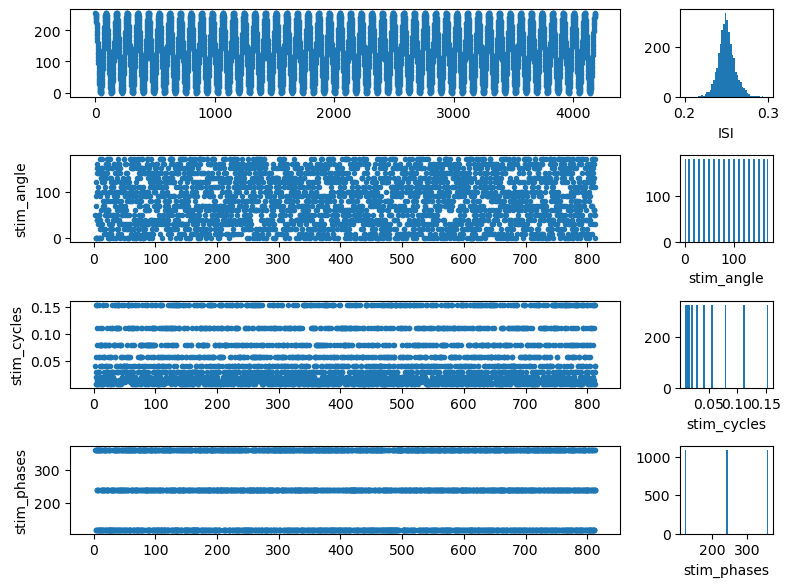

In [ ]:
from placefield_dynamics.orientation_detection.utils import plot_stimulus

plot_stimulus(stimulus_data)

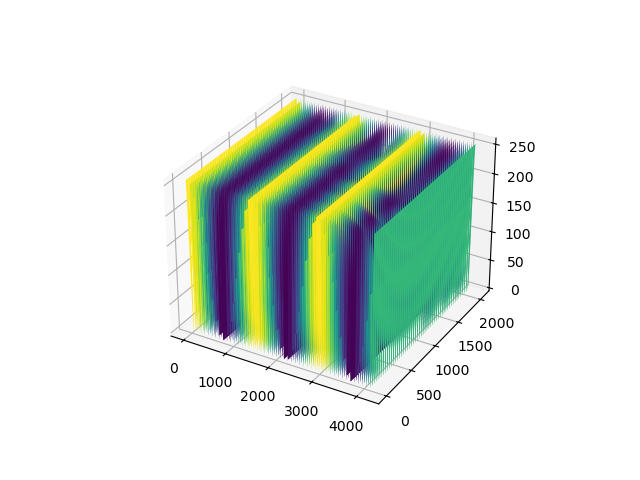

In [8]:

%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
X,Y = np.meshgrid(np.arange(stimulus_data["grating"].shape[1]),
                   np.arange(stimulus_data["grating"].shape[0]))
# ax.plot_trisurf(X.flatten(), Y.flatten(), stimulus_data["grating"].flatten(), cmap='viridis')
ax.plot_surface(X, Y, stimulus_data["grating"], cmap='viridis',antialiased=True)

In [22]:
print(stimulus_data.keys())
stimulus_data["FR"]

dict_keys(['grating', 'angle', 'CPD', 'nPhases', 'nSeq', 'baseline_sec', 'stimulus_sec', 'blank_sec', 'stim_cycles', 'stim_phases', 'stim_angle', 'DegreesPerSecond', 'contrast', 'stimulus_clock', 'omega', 'flicker_frequency_Hz', 'flicker_repeats', 'white_percentage', 'depth_um', 'scanspeed', 'zoom', 'pxh', 'pxw', 'LPpercent', 'FR', 'ID', 'frame_times'])


'30.05'

## load neuron detection data and calculate stimulus-dependent firingmaps

In [123]:
from placefield_dynamics.orientation_detection.utils.utils_analysis import (
    calculate_firing_maps,
    get_spikes,
    get_unique_stimulus_values,
)

spikes = get_spikes(caiman_data["S"], f=f)
event_counts, dwelltime = calculate_firing_maps(
    stimulus_data=stimulus_data, spikes=spikes, dt_onset=0.2, dt_response=0.25
)

{'extent': [np.uint8(0), np.uint8(170), np.float64(0.007899999999999999), np.float64(0.15490000000000004)], 'aspect': 'auto', 'origin': 'lower'}


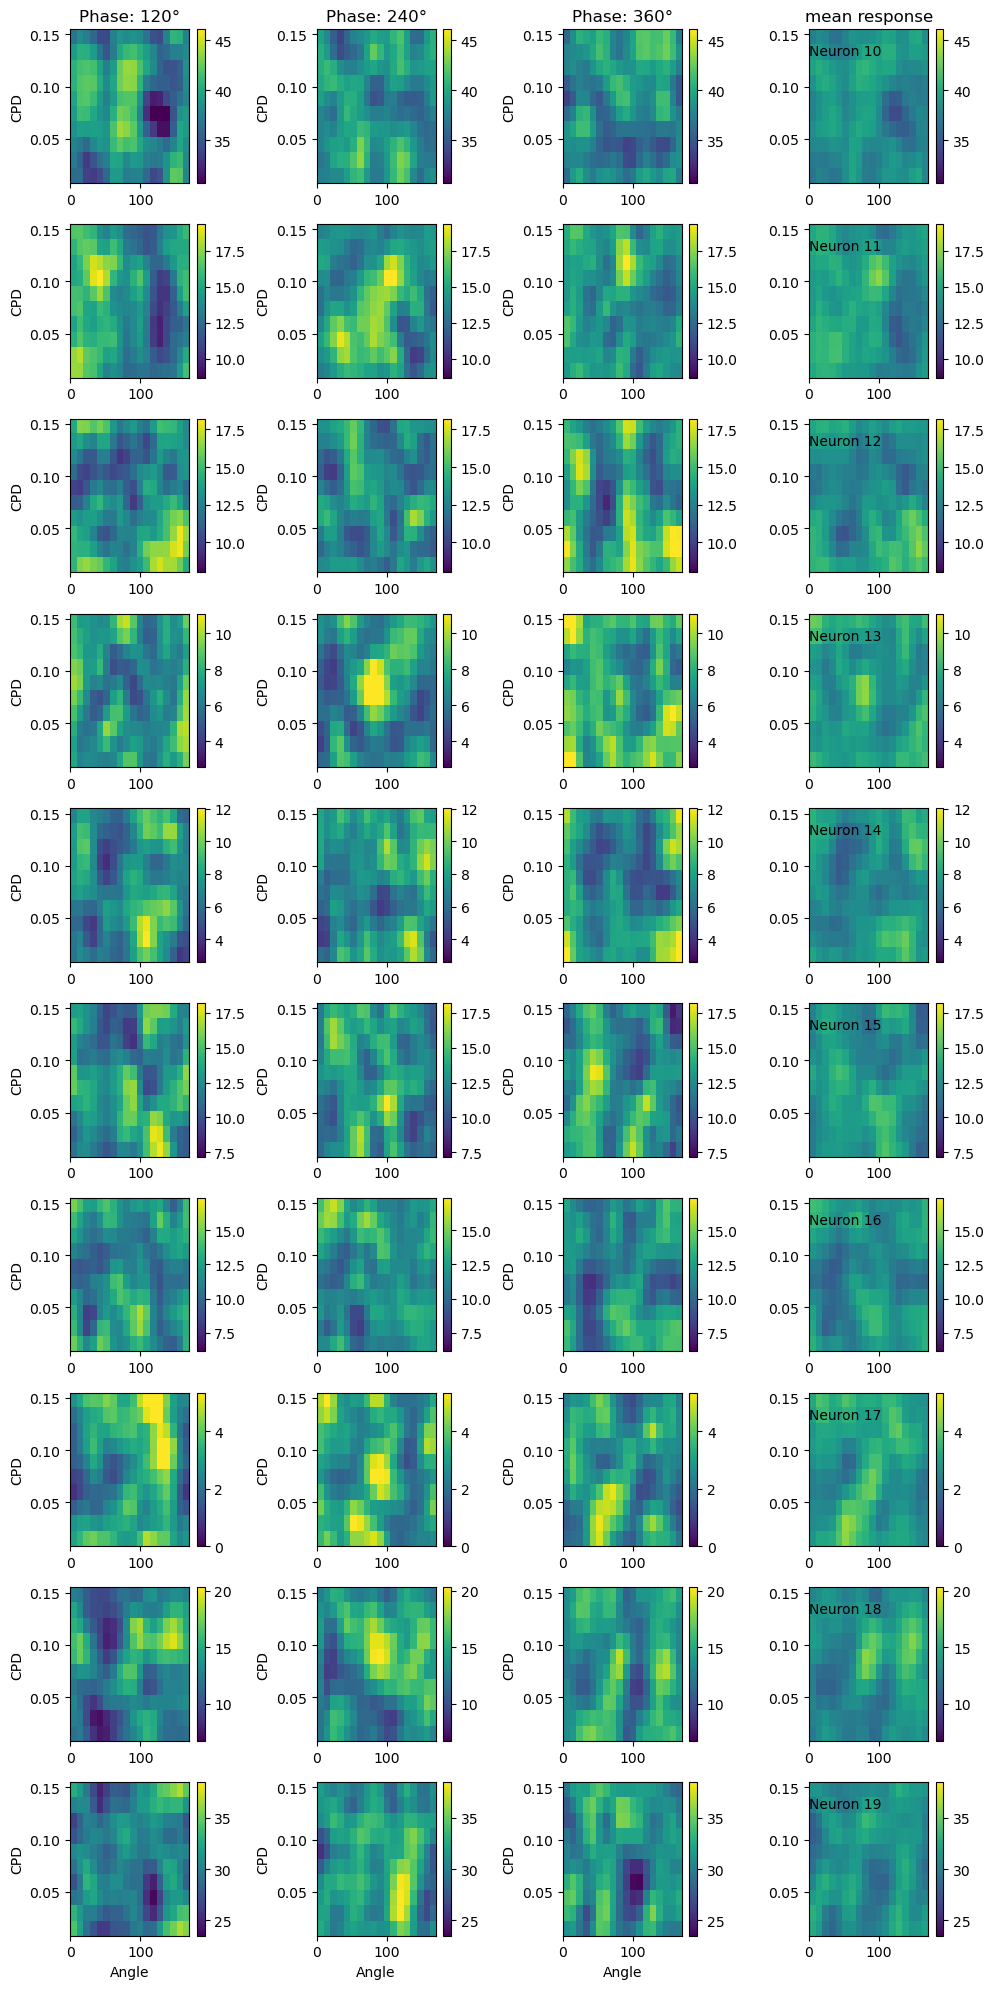

In [124]:
from placefield_dynamics.orientation_detection.utils.utils_display import (
    plot_firing_maps,
)

neurons = range(10, 20)
unique_values = get_unique_stimulus_values(stimulus_data)
plot_firing_maps(
    firing_maps=event_counts / (dwelltime),
    neurons=neurons,
    unique_values=unique_values,
)

In [128]:
meta_data["CaimanMeta"]

{'p': 'F:\\SB\\2pCaI\\Data\\redetected\\ID20\\20230913\\',
 'mouseID': 'ID20',
 'recDate': MatlabOpaque([(b'', b'MCOS', b'datetime', array([3707764736,          2,          1,          1,          1,
                               1], dtype=uint32))                                                            ],
              dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')]),
 'genotype': 'WT',
 'group': 1,
 'DOB': MatlabOpaque([(b'', b'MCOS', b'datetime', array([3707764736,          2,          1,          1,          2,
                               1], dtype=uint32))                                                            ],
              dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')]),
 'num_frames': array([24518, 24505, 24506], dtype=uint16),
 'Stimulus': array([array([[9.10000000e+01, 1.00000000e+02, 3.00107510e+00, ...,
                1.00000000e+00, 5.74438195e-02, 1.20000000e+02],
               [1.00000000e+02, 1.07000000e+02, 3.30124270e+00, ...,
 

In [ ]:
# f = 30.05

# caiman_data = load_data(caimanPath)
# n_cells = caiman_data["C"].shape[0]
# data["frame_times"] = np.arange(caiman_data["C"].shape[1]) / f

# spikes = np.zeros((n_cells, len(data["frame_times"])))
# for n in range(n_cells):
#     spikes[n, :], _, _ = get_spiking_data(caiman_data["S"][n, :], f=f)

# unique_values = {
#     "phases": np.unique(data["stim_phases"]),
#     "angles": data["angle"],
#     "cycles": data["CPD"],
# }

In [ ]:
dT = 2.0

# spike triggered average
STA = np.full(
    (
        len(unique_values["phases"]),
        len(unique_values["angles"]),
        len(unique_values["cycles"]),
        int(np.ceil(f * dT)),  # number of frames to consider for STA
    ),
    np.nan,
)

for prod in itertools.product(
    enumerate(unique_values["phases"]),
    enumerate(unique_values["angles"]),
    enumerate(unique_values["cycles"]),
):
    idx, elems = zip(*prod)
    # print(f"Processing phase {elems[0]}, angle {elems[1]}, cycle {elems[2]}")

    idxes = (
        (data["stim_phases"] == elems[0])
        & (data["stim_angle"] == elems[1])
        & (data["stim_cycles"] == elems[2])
    ).flatten()

    times = data["stimulus_clock"][idxes, :]
    for t, time in enumerate(times):
        start_idx = np.argmin(np.abs(data["frame_times"] - (time[0])))
        # end_idx = np.argmin(np.abs(data["frame_times"] - time[1]))
        end_idx = np.argmin(np.abs(data["frame_times"] - (time[0] + dT)))
        # print(start_idx, end_idx, end_idx - start_idx)
        STA[idx[0], idx[1], idx[2], : (end_idx - start_idx)] = spikes[
            :, start_idx:end_idx
        ].mean(axis=0)

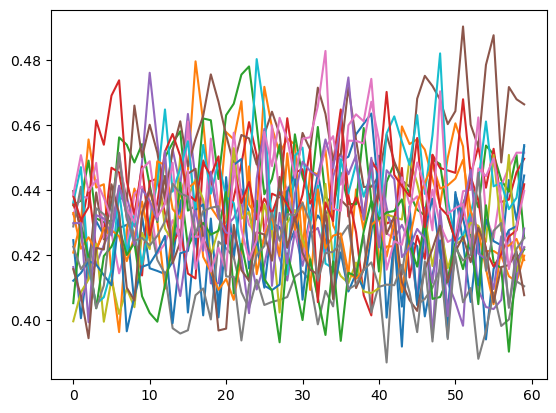

In [ ]:
plt.figure()
plt.plot(STA.mean(axis=(0, 2)).T)

In [39]:
unique_values["angles"].shape

(18,)

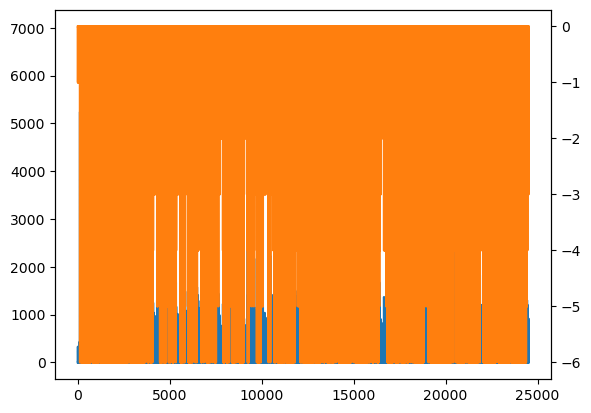

(71, 24518) 24430.65


In [40]:
n = 1
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax2 = ax.twinx()
ax.plot(caiman_data["S"][n, :])
ax2.plot(-spikes[n, :], color="tab:orange")
plt.show()

print(spikes.shape, 813 * 30.05)

In [10]:
n = 6
responses = firing_maps[..., n]


def get_prediction(responses, phase, smooth=False, plot=False):
    _, orientations, cycles = responses.shape
    phases = np.array([120, 240, 360]) * np.pi / 180  # Convert to radians
    # phases = np.array([120, 240]) * np.pi / 180  # Convert to radians

    # Fit sinusoidal model
    A = np.zeros((orientations, cycles))
    phi_0 = np.zeros((orientations, cycles))

    for i in range(orientations):
        for j in range(cycles):
            y = responses[:, i, j]
            x = phases
            # Fit the cosine model: y = A * cos(x - phi_0)
            A[i, j] = np.sqrt(
                (y * np.cos(x)).sum() ** 2 + (y * np.sin(x)).sum() ** 2
            ) / len(phases)
            phi_0[i, j] = np.arctan2((y * np.sin(x)).sum(), (y * np.cos(x)).sum())
    # print(phi_0)

    if smooth or plot:
        smoothed_phi = gauss_smooth(np.sin(phi_0), (1.0, 0.0), mode="wrap")
        smoothed_phi = gauss_smooth(smoothed_phi, (0.0, 1.0), mode="constant")
        smoothed_phi = np.arcsin(smoothed_phi)
    if plot:
        fig = plt.figure(figsize=(8, 3))
        ax = fig.add_subplot(121)
        img = ax.imshow(
            gauss_smooth(phi_0.T, (1.0, 1.0)),
            origin="lower",
            aspect="auto",
            cmap="bwr",
            clim=[-1, 1],
        )
        # img = ax.imshow(phi_0.T, origin="lower", aspect="auto",cmap='bwr',clim=[-3,3])
        plt.colorbar(img)
        ax = fig.add_subplot(122)
        # smoothed_phi = np.arcsin(gauss_smooth(np.sin(phi_0),(1.,1.)))
        img = ax.imshow(
            smoothed_phi.T, origin="lower", aspect="auto", cmap="bwr", clim=[-0.5, 0.5]
        )
        plt.colorbar(img)

    # Predict R_240
    phi_phase = phase * np.pi / 180  # Convert to radians
    if smooth:
        R_phase_pred = A * np.cos(phi_phase - smoothed_phi)
    else:
        R_phase_pred = A * np.cos(phi_phase - phi_0)

    return R_phase_pred

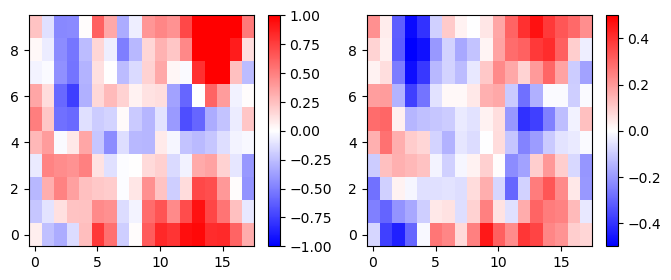

In [11]:
# vals = get_prediction(gauss_smooth(firing_maps[..., n],(0,2.,2.)), 120,plot=True)
vals = get_prediction(firing_maps[..., n], 240, plot=True)

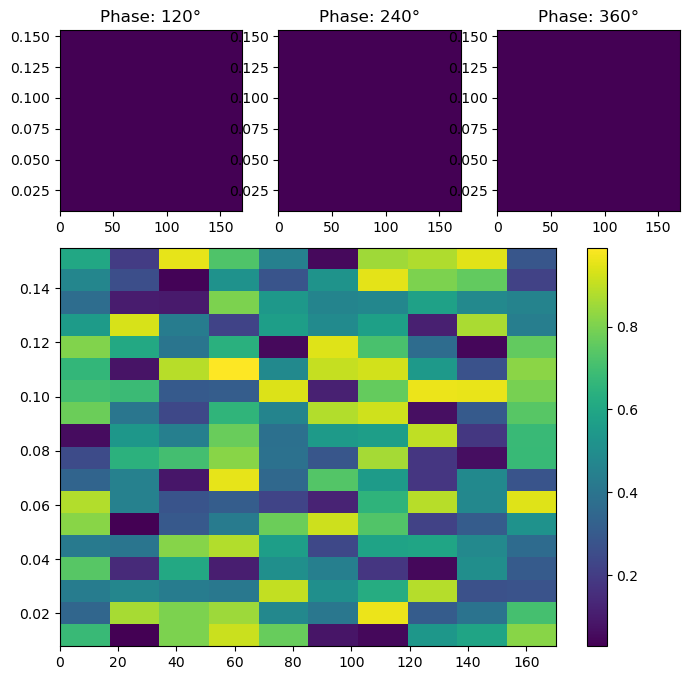

interactive(children=(IntSlider(value=0, description='phase', max=360, step=10), Output()), _dom_classes=('wid…

<Figure size 640x480 with 0 Axes>

In [154]:
plt.close("all")
# %matplotlib widget
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(3, 3)
smooth_fact = 1.0

extents = [
    data["angle"].min(),
    data["angle"].max(),
    data["CPD"].min(),
    data["CPD"].max(),
]

phases = [120, 240, 360]
for i, phase in enumerate(phases):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(
        gauss_smooth(responses[i, ...], (smooth_fact, smooth_fact)).T,
        extent=extents,
        aspect="auto",
        origin="lower",
        clim=[6000, 11000],
    )
    plt.setp(ax, title=f"Phase: {phase}°")


phases = np.linspace(0, 300, 6)
ax = fig.add_subplot(gs[1:, :])
img = ax.imshow(
    np.random.rand(*responses.shape[1:]),
    cmap="viridis",
    aspect="auto",
    origin="lower",
    extent=extents,
)
# img.set_clim([-500,800])
plt.colorbar(img)


@interact(phase=(0, 360, 10))
def update_plot(phase=0):

    vals = gauss_smooth(
        get_prediction(firing_maps[..., n], phase, smooth=False),
        (smooth_fact, smooth_fact),
    )
    # print(vals)
    img.set_data(vals.T)
    img.set_clim([vals.min(), vals.max()])


plt.tight_layout()

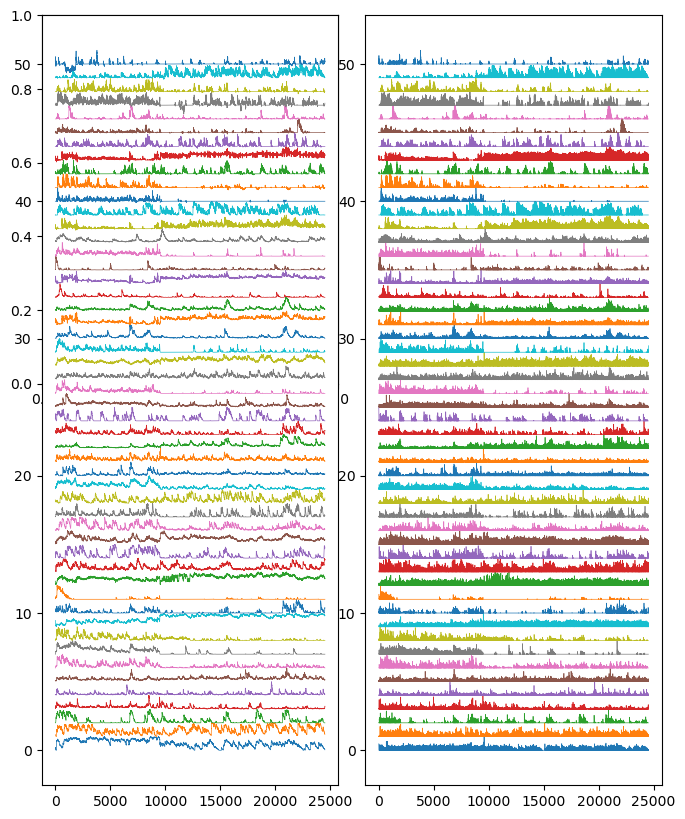

In [42]:
# %matplotlib widget
fig = plt.figure(figsize=(8, 10))

gs = fig.add_gridspec(4, 4)
ax = fig.add_subplot(gs[:2, :2])

# dims = (512,512)
# Cn = np.zeros(dims)
# for a in caiman_data['A'].T:
#     # print(a.shape)
#     Cn += (a/a.sum()).reshape(dims)
# ax.imshow(Cn)

ax = fig.add_subplot(gs[:, :2])
for i, c in enumerate(caiman_data["C"]):
    ax.plot(c / c.max() + i, linewidth=0.5)
    if i >= 50:
        break

ax = fig.add_subplot(gs[:, 2:])
for i, s in enumerate(caiman_data["S"]):
    ax.plot(s / s.max() + i, linewidth=0.5)
    if i >= 50:
        break
# ax.plot()

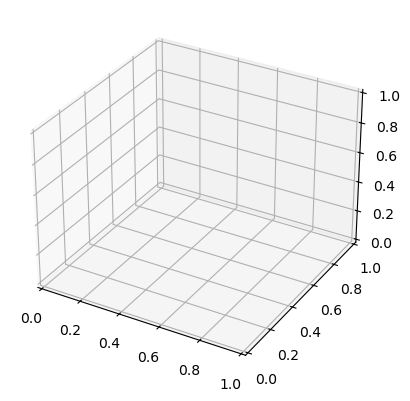

interactive(children=(FloatSlider(value=0.0, description='mean_x', max=180.0, min=-180.0, step=10.0), FloatSli…

In [15]:
import numpy as np
import matplotlib.pyplot as plt


def covariance_matrix(standard_deviation, theta):
    # Covariance matrix
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    Lambda = np.diag(standard_deviation**2)
    return R @ Lambda @ R.T


# Gaussian function
def multivariate_gaussian(pos, mu, Sigma):
    # n = mu.shape[0]
    diff = pos - mu
    inv_Sigma = np.linalg.inv(Sigma)
    det_Sigma = np.linalg.det(Sigma)
    norm_const = 1.0 / (2 * np.pi * np.sqrt(det_Sigma))
    result = np.einsum("...i,ij,...j->...", diff, inv_Sigma, diff)
    return norm_const * np.exp(-0.5 * result)


# Generate grid for visualization
x, y = np.linspace(-100, 100, 100), np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# Z = multivariate_gaussian(pos, mu=np.zeros(2), Sigma=np.eye(2))
# img = ax.contour(X, Y, Z, levels=10, cmap='viridis')


@interact(
    mean_x=(-180, 180, 10.0),
    mean_y=(-1, 1, 0.1),
    sigma_x=(1.0, 50.0, 1.0),
    sigma_y=(0.01, 1, 0.01),
    theta=(0, 180, 10),
)
def update_plot(mean_x=0, mean_y=0, sigma_x=1, sigma_y=1, theta=0):

    theta *= np.pi / 180.0

    # Parameters
    mu = np.array([mean_x, mean_y])
    standard_deviation = np.array([sigma_x, sigma_y])

    Sigma = covariance_matrix(standard_deviation, theta)
    Z = multivariate_gaussian(pos, mu, Sigma)

    ax.clear()
    # ax.contour(X, Y, Z, levels=10, cmap="viridis")
    ax.plot_surface(X, Y, Z, cmap="viridis")
    # img.set_data(Z)


# Plot
plt.setp(ax, title="Rotated 2D Gaussian", xlabel="X-axis", ylabel="Y-axis")
ax.axis("equal")
plt.show()